In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

from keras_preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model  
from keras.layers import AveragePooling2D
from keras.applications.densenet import DenseNet121
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import Activation, Dropout, Flatten, Dense  
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  
from keras import regularizers
from keras.applications.densenet import preprocess_input

from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

## Load data

In [2]:
# parameters
data_dir = '/kaggle/input/corn-or-maize-leaf-disease-dataset/data/'
image_size = (128, 128) #Original: (256, 256)
batch_size = 16
val_split = 0.2
epochs = 10

labels = os.listdir(data_dir)

In [3]:
# size of data available to train the model
for label in labels:
    directory = os.path.join(data_dir, label)
    print("Images of label \"" + label + "\":\t", len(os.listdir(directory)))

Images of label "Common_Rust":	 1306
Images of label "Blight":	 1146
Images of label "Healthy":	 1162
Images of label "Gray_Leaf_Spot":	 574


In [4]:
# size of images
import matplotlib.image as mpimg

directory = os.path.join(data_dir, labels[0])
path = os.path.join(directory, os.listdir(directory)[0])
image = mpimg.imread(path)
image.shape

(256, 256, 3)

In [5]:
# Training dataset
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=val_split)

train_ds = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    classes=labels
)

# Test dataset
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=val_split)

test_ds = test_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    classes=labels
)

Found 3352 images belonging to 4 classes.
Found 836 images belonging to 4 classes.


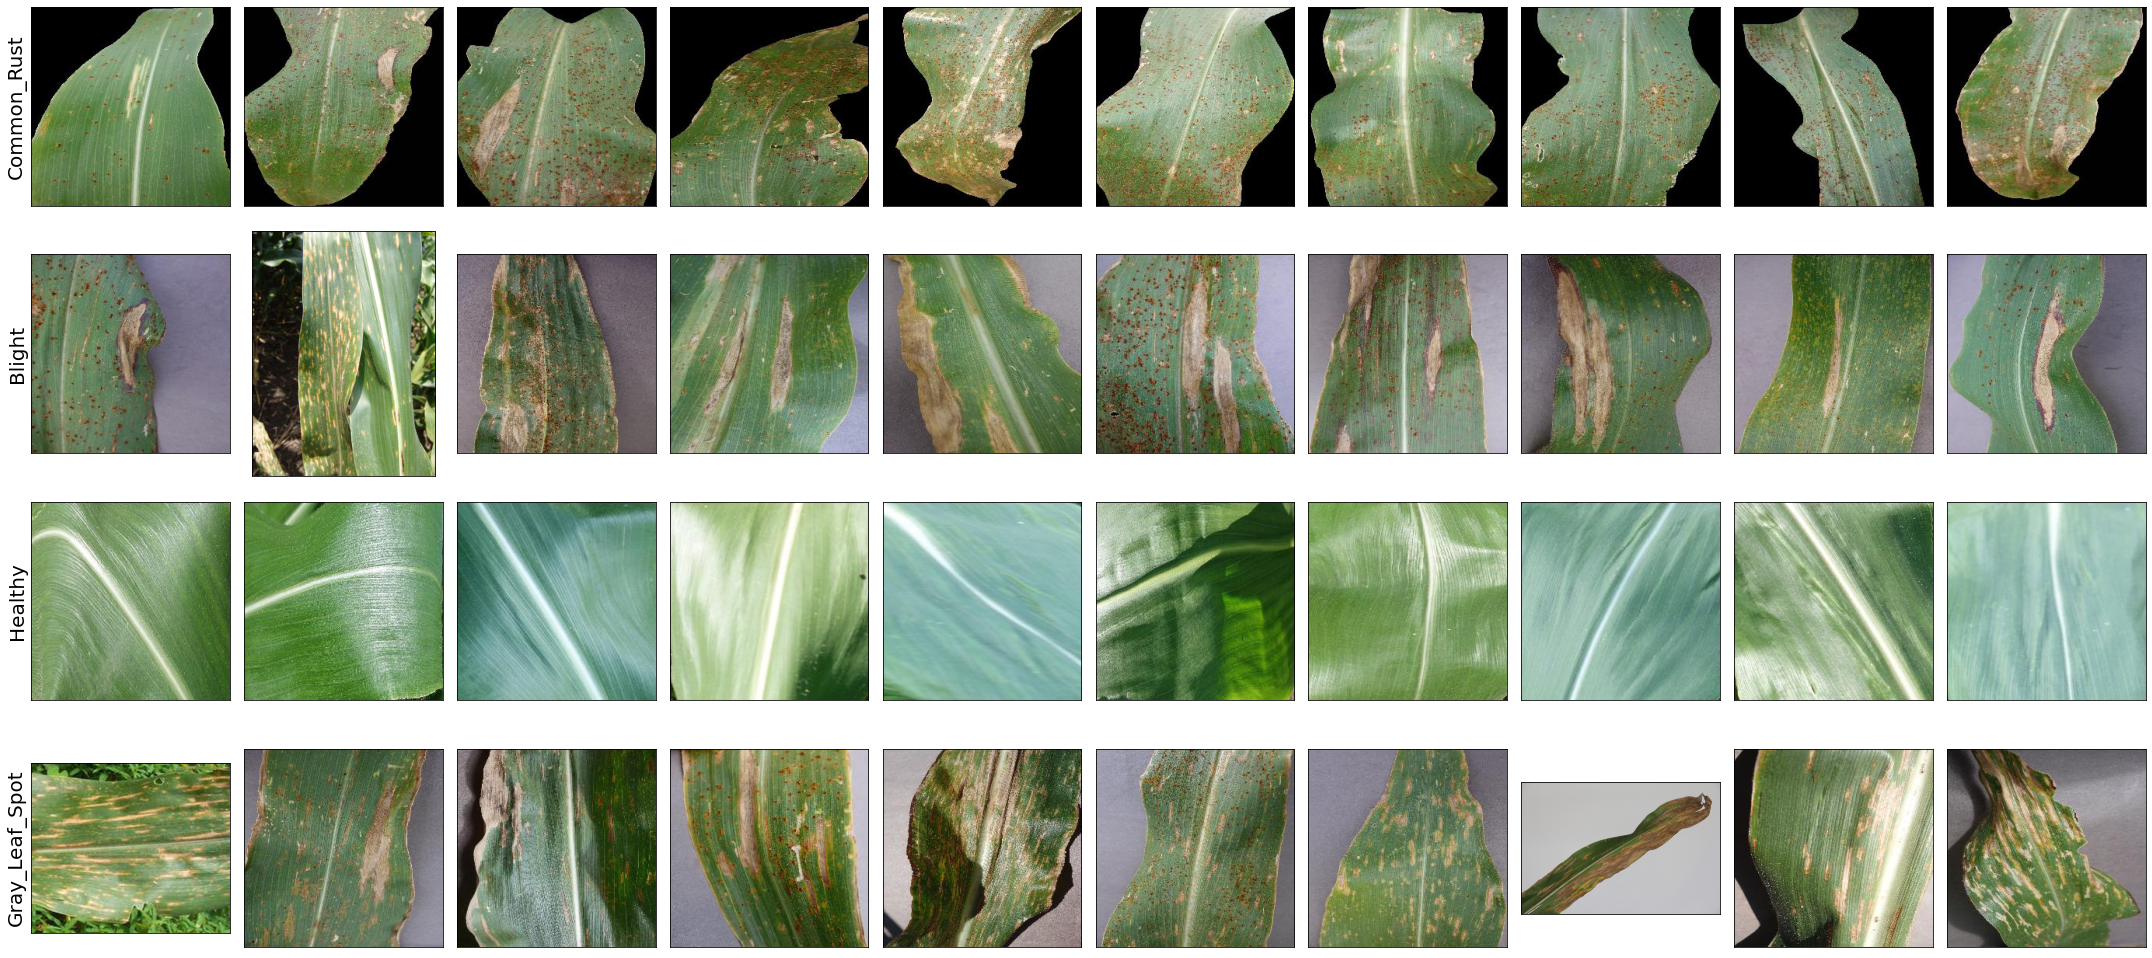

In [6]:
# plotting images of each class
import matplotlib.pyplot as plt

plt.figure(figsize=(30,14))

for i in range(len(labels)):
    directory = os.path.join(data_dir, labels[i])
    for j in range(10):
        path = os.path.join(directory, os.listdir(directory)[j])
        img = mpimg.imread(path)
        
        plt.subplot(len(labels), 10, i*10 + j + 1)
        plt.imshow(img)
        
        if j == 0:
            plt.ylabel(labels[i], fontsize=20)
        
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.tight_layout()
plt.show()

# Transfer learning models

In [7]:
# = = = = = DenseNet121 CNN Model = = = = =
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(image_size+(3,)))
base_model.trainable = False

# = = = = = TOP NN Model = = = = =
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# = = = = = Coupling = = = = =
predictions = Dense(len(labels), activation='softmax')(x)

# = = = = = Complete Model = = = = =
DenseNet121_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

DenseNet121_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=["accuracy"],)
#model.summary()


29097984/29084464 [==============================] - 0s 0us/step


In [8]:
# = = = = = InceptionV3 CNN Model = = = = =
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(image_size+(3,)))
base_model.trainable = False

# = = = = = TOP NN Model = = = = =
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# = = = = = Coupling = = = = =
predictions = Dense(len(labels), activation='softmax')(x)

# = = = = = Complete Model = = = = =
InceptionV3_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

InceptionV3_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=["accuracy"],)
#model.summary()

87924736/87910968 [==============================] - 1s 0us/step


In [9]:
# = = = = = MobileNetV2 CNN Model = = = = =
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(image_size+(3,)))
base_model.trainable = False

# = = = = = TOP NN Model = = = = =
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# = = = = = Coupling = = = = =
predictions = Dense(len(labels), activation='softmax')(x)

# = = = = = Complete Model = = = = =
MobileNetV2_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

MobileNetV2_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=["accuracy"],)
#model.summary()

9420800/9406464 [==============================] - 0s 0us/step


In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1, min_delta=1e-4)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_delta=1e-4)  

callbacks_list = [early_stop, reduce_lr] 

In [11]:
DenseNet121_history = DenseNet121_model.fit(  
    train_ds,
    epochs=epochs,
    validation_data=test_ds,
    validation_steps=len(test_ds),
    callbacks=callbacks_list
)

Epoch 1/10
210/210 [==============================] - 43s 145ms/step - loss: 0.4822 - accuracy: 0.8365 - val_loss: 0.2500 - val_accuracy: 0.8923
Epoch 2/10
210/210 [==============================] - 16s 77ms/step - loss: 0.2853 - accuracy: 0.8884 - val_loss: 0.2611 - val_accuracy: 0.9103
Epoch 3/10
210/210 [==============================] - 16s 77ms/step - loss: 0.2169 - accuracy: 0.9123 - val_loss: 0.2835 - val_accuracy: 0.9007

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/10
210/210 [==============================] - 17s 79ms/step - loss: 0.1216 - accuracy: 0.9561 - val_loss: 0.2149 - val_accuracy: 0.9199
Epoch 5/10
210/210 [==============================] - 16s 77ms/step - loss: 0.0988 - accuracy: 0.9654 - val_loss: 0.2147 - val_accuracy: 0.9222
Epoch 6/10
210/210 [==============================] - 16s 77ms/step - loss: 0.0868 - accuracy: 0.9690 - val_loss: 0.2204 - val_accuracy: 0.9187
Epoch 7/10
210/210 [==============================] -

In [12]:
InceptionV3_history = InceptionV3_model.fit(  
    train_ds,
    epochs=epochs,
    validation_data=test_ds,
    validation_steps=len(test_ds),
    callbacks=callbacks_list
)

Epoch 1/10
210/210 [==============================] - 22s 85ms/step - loss: 0.6437 - accuracy: 0.7748 - val_loss: 0.5028 - val_accuracy: 0.8278
Epoch 2/10
210/210 [==============================] - 16s 78ms/step - loss: 0.3789 - accuracy: 0.8589 - val_loss: 0.5012 - val_accuracy: 0.8086
Epoch 3/10
210/210 [==============================] - 16s 75ms/step - loss: 0.2869 - accuracy: 0.8893 - val_loss: 0.3748 - val_accuracy: 0.8696
Epoch 4/10
210/210 [==============================] - 16s 76ms/step - loss: 0.2510 - accuracy: 0.9042 - val_loss: 0.3663 - val_accuracy: 0.8840
Epoch 5/10
210/210 [==============================] - 16s 76ms/step - loss: 0.1749 - accuracy: 0.9341 - val_loss: 0.6168 - val_accuracy: 0.8218
Epoch 6/10
210/210 [==============================] - 16s 77ms/step - loss: 0.1592 - accuracy: 0.9433 - val_loss: 0.3888 - val_accuracy: 0.8648

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/10
210/210 [==============================] - 

In [13]:
MobileNetV2_history = MobileNetV2_model.fit(  
    train_ds,
    epochs=epochs,
    validation_data=test_ds,
    validation_steps=len(test_ds),
    callbacks=callbacks_list
)

Epoch 1/10
210/210 [==============================] - 19s 79ms/step - loss: 0.4593 - accuracy: 0.8476 - val_loss: 0.2738 - val_accuracy: 0.8995
Epoch 2/10
210/210 [==============================] - 16s 75ms/step - loss: 0.2529 - accuracy: 0.9120 - val_loss: 0.3178 - val_accuracy: 0.8935
Epoch 3/10
210/210 [==============================] - 15s 73ms/step - loss: 0.1695 - accuracy: 0.9406 - val_loss: 0.2438 - val_accuracy: 0.9258
Epoch 4/10
210/210 [==============================] - 15s 72ms/step - loss: 0.1552 - accuracy: 0.9424 - val_loss: 0.2408 - val_accuracy: 0.9211
Epoch 5/10
210/210 [==============================] - 16s 75ms/step - loss: 0.1271 - accuracy: 0.9553 - val_loss: 0.2540 - val_accuracy: 0.9199
Epoch 6/10
210/210 [==============================] - 16s 74ms/step - loss: 0.1106 - accuracy: 0.9633 - val_loss: 0.2737 - val_accuracy: 0.9211

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/10
210/210 [==============================] - 

## Results: accuracy graphs & confusion matrix

In [14]:
# comparison of results
results = pd.DataFrame(columns=['model','accuracy', 'val_accuracy'])

results = results.append({
    'model': 'DenseNet121',
    'accuracy': round(DenseNet121_history.history['accuracy'][-1],2),
    'val_accuracy': round(DenseNet121_history.history['val_accuracy'][-1],2),
    }, ignore_index=True)

results = results.append({
    'model': 'InceptionV3',
    'accuracy': round(InceptionV3_history.history['accuracy'][-1],2),
    'val_accuracy': round(InceptionV3_history.history['val_accuracy'][-1],2),
    }, ignore_index=True)

results = results.append({
    'model': 'MobileNetV2',
    'accuracy': round(MobileNetV2_history.history['accuracy'][-1],2),
    'val_accuracy': round(MobileNetV2_history.history['val_accuracy'][-1],2),
    }, ignore_index=True)

results

,model,accuracy,val_accuracy
0,DenseNet121,0.98,0.92
1,InceptionV3,0.98,0.87
2,MobileNetV2,0.99,0.93


In [15]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=2, subplot_titles=("train_loss", "val_loss", "train_accuracy", "val_accuracy"))

#====== loss ======
fig.add_trace(go.Scatter(
    y=DenseNet121_history.history['loss'],
    mode='lines+markers',
    name=f'DenseNet121',
    line=dict(color='blue'),
), row=1, col=1)

fig.add_trace(go.Scatter(
    y=InceptionV3_history.history['loss'],
    mode='lines+markers',
    name=f'InceptionV3',
    line=dict(color='red'),
), row=1, col=1)

fig.add_trace(go.Scatter(
    y=MobileNetV2_history.history['loss'],
    mode='lines+markers',
    name=f'MobileNetV2',
    line=dict(color='green'),
), row=1, col=1)

#===== val_loss ======
fig.add_trace(go.Scatter(
    y=DenseNet121_history.history['val_loss'],
    mode='lines+markers',
    name=f'DenseNet121 val_loss',
    line=dict(color='blue'),
    showlegend=False
), row=1, col=2)

fig.add_trace(go.Scatter(
    y=InceptionV3_history.history['val_loss'],
    mode='lines+markers',
    name=f'InceptionV3 val_loss',
    line=dict(color='red'),
    showlegend=False
), row=1, col=2)

fig.add_trace(go.Scatter(
    y=MobileNetV2_history.history['val_loss'],
    mode='lines+markers',
    name=f'MobileNetV2 val_loss',
    line=dict(color='green'),
    showlegend=False
), row=1, col=2)

#===== train_accuracy ======
fig.add_trace(go.Scatter(
    y=DenseNet121_history.history['accuracy'],
    mode='lines+markers',
    name=f'DenseNet121 train_accuracy',
    line=dict(color='blue'),
    showlegend=False
), row=2, col=1)

fig.add_trace(go.Scatter(
    y=InceptionV3_history.history['accuracy'],
    mode='lines+markers',
    name=f'InceptionV3 train_accuracy',
    line=dict(color='red'),
    showlegend=False
), row=2, col=1)

fig.add_trace(go.Scatter(
    y=MobileNetV2_history.history['accuracy'],
    mode='lines+markers',
    name=f'MobileNetV2 train_accuracy',
    line=dict(color='green'),
    showlegend=False
), row=2, col=1)

#===== val_accuracy ======
fig.add_trace(go.Scatter(
    y=DenseNet121_history.history['val_accuracy'],
    mode='lines+markers',
    name=f'DenseNet121 val_accuracy',
    line=dict(color='blue'),
    showlegend=False
), row=2, col=2)

fig.add_trace(go.Scatter(
    y=InceptionV3_history.history['val_accuracy'],
    mode='lines+markers',
    name=f'InceptionV3 val_accuracy',
    line=dict(color='red'),
    showlegend=False
), row=2, col=2)

fig.add_trace(go.Scatter(
    y=MobileNetV2_history.history['val_accuracy'],
    mode='lines+markers',
    name=f'MobileNetV2 val_accuracy',
    line=dict(color='green'),
    showlegend=False
), row=2, col=2)

fig.update_xaxes(title_text='Epoch')
fig.update_layout(height=800, width=1000, title_text="Training History Metrics")
fig.show()

In [16]:
DenseNet121_actual = []
DenseNet121_pred = []
InceptionV3_actual = []
InceptionV3_pred = []
MobileNetV2_actual = []
MobileNetV2_pred = []

def predict_one(model,actual,prediction):  
    image_batch, classes_batch = next(test_ds)
    predicted_batch = model.predict(image_batch)
    for k in range(0,image_batch.shape[0]):
        pred = predicted_batch[k]
        the_pred = np.argmax(pred)
        prediction.append(the_pred)
        the_class = np.argmax(classes_batch[k])
        actual.append(the_class)
 
for i in range(0,len(test_ds)):
    predict_one(DenseNet121_model,DenseNet121_actual,DenseNet121_pred)
    
for i in range(0,len(test_ds)):
    predict_one(InceptionV3_model,InceptionV3_actual,InceptionV3_pred)
    
for i in range(0,len(test_ds)):
    predict_one(MobileNetV2_model,MobileNetV2_actual,MobileNetV2_pred)

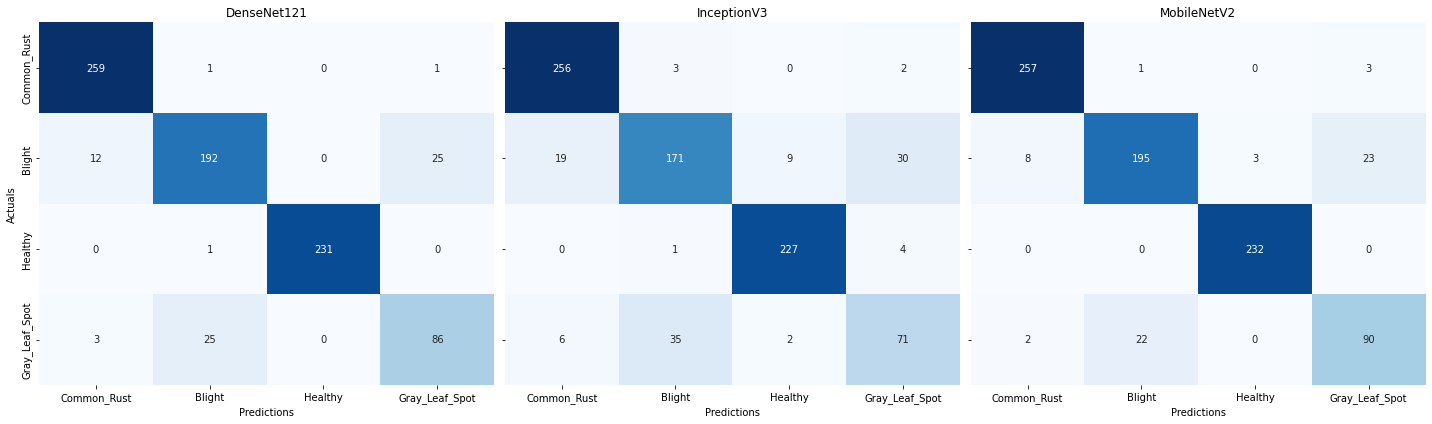

In [17]:
# Predictions and actuals have already been collected
cm1 = confusion_matrix(DenseNet121_actual, DenseNet121_pred)
cm2 = confusion_matrix(InceptionV3_actual, InceptionV3_pred)
cm3 = confusion_matrix(MobileNetV2_actual, MobileNetV2_pred)

# Setting up the subplot
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Plotting each confusion matrix
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", ax=axes[0], cbar=False, xticklabels=labels, yticklabels=labels)
axes[0].set_title('DenseNet121')
axes[0].set_xlabel('Predictions')
axes[0].set_ylabel('Actuals')

sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", ax=axes[1], cbar=False, xticklabels=labels, yticklabels=labels)
axes[1].set_title('InceptionV3')
axes[1].set_xlabel('Predictions')
# No need for 'set_ylabel' as 'sharey=True' in subplots

sns.heatmap(cm3, annot=True, fmt="d", cmap="Blues", ax=axes[2], cbar=False, xticklabels=labels, yticklabels=labels)
axes[2].set_title('MobileNetV2')
axes[2].set_xlabel('Predictions')
# No need for 'set_ylabel' here either

plt.tight_layout()
plt.show()